## Solutions for Stellar Physics Lab 1

In [1]:
## preliminaries
from astroquery.simbad import Simbad
from astroquery.ipac.irsa import Irsa
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, least_squares
from scipy.integrate import quad
%matplotlib inline

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### 1) Stellar Photometry
I'm going to do this at the command line just as an example in using Python

In [2]:
### let's get a list of fields for our Simbad query, because we're going to have to add some
Simbad.list_votable_fields()

--NOTES--

1. The parameter filtername must correspond to an existing filter. Filters include: B,V,R,I,J,K.  They are checked by SIMBAD but not astroquery.simbad

2. Fields beginning with rvz display the data as it is in the database. Fields beginning with rv force the display as a radial velocity. Fields beginning with z force the display as a redshift

3. For each measurement catalog, the VOTable contains all fields of the first measurement. When applicable, the first measurement is the mean one. 

Available VOTABLE fields:

bibcodelist(y1-y2)
biblio
cel
cl.g
coo(opt)
coo_bibcode
coo_err_angle
coo_err_maja
coo_err_mina
coo_qual
coo_wavelength
coordinates
dec(opt)
dec_prec
diameter
dim
dim_angle
dim_bibcode
dim_incl
dim_majaxis
dim_minaxis
dim_qual
dim_wavelength
dimensions
distance
distance_result
einstein
fe_h
flux(filtername)
flux_bibcode(filtername)
flux_error(filtername)
flux_name(filtername)
flux_qual(filtername)
flux_system(filtername)
flux_unit(filtername)
fluxdata(filtername)

In [3]:
### let's add "fluxes" (these are actually magnitudes), for some of the 
### filters that we see for Spica:
### http://simbad.u-strasbg.fr/simbad/sim-id?Ident=spica&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id)
customSimbad = Simbad()
customSimbad.add_votable_fields('flux(U)','flux(B)','flux(V)','flux(R)',
                                'flux(I)','flux(J)','flux(H)','flux(K)',
                                'flux(u)','flux(g)','flux(r)','flux(i)',
                                'flux(z)')

### 1.2) Stars to Start With

In [4]:
object_list = ['Spica','Arcturus','Proxima Centauri']
magnitude_dict = {}
for o in object_list:
    result_table = customSimbad.query_object(o)
    magnitude_dict[o] = []
    for filt in 'UBVRIJHK':
        magnitude_dict[o] += [float(result_table[f"FLUX_{filt}"])]
        
    for filt in 'ugriz':
        magnitude_dict[o] += [float(result_table[f"FLUX_{filt}"])]

/var/folders/gb/ltvsdtcj74j7xf7pyycyvf7r000g2p/T/ipykernel_53446/908728172.py:10: UserWarning: Warning: converting a masked element to nan.
  magnitude_dict[o] += [float(result_table[f"FLUX_{filt}"])]
/var/folders/gb/ltvsdtcj74j7xf7pyycyvf7r000g2p/T/ipykernel_53446/908728172.py:10: UserWarning: Warning: converting a masked element to nan.
  magnitude_dict[o] += [float(result_table[f"FLUX_{filt}"])]
/var/folders/gb/ltvsdtcj74j7xf7pyycyvf7r000g2p/T/ipykernel_53446/908728172.py:10: UserWarning: Warning: converting a masked element to nan.
  magnitude_dict[o] += [float(result_table[f"FLUX_{filt}"])]


In [5]:
### we've put together a dictionary of mags for each star
magnitude_dict

{'Spica': [-0.20000000298023224,
  0.7400000095367432,
  0.9700000286102295,
  1.059999942779541,
  1.2999999523162842,
  1.5,
  1.5399999618530273,
  1.6399999856948853,
  nan,
  nan,
  nan,
  nan,
  nan],
 'Arcturus': [2.4600000381469727,
  1.1799999475479126,
  -0.05000000074505806,
  -1.0299999713897705,
  -1.6799999475479126,
  -2.252000093460083,
  -2.809999942779541,
  -2.9110000133514404,
  nan,
  nan,
  nan,
  nan,
  nan],
 'Proxima Centauri': [14.210000038146973,
  12.949999809265137,
  11.130000114440918,
  9.449999809265137,
  7.409999847412109,
  5.35699987411499,
  4.835000038146973,
  4.383999824523926,
  nan,
  nan,
  nan,
  nan,
  nan]}

In [6]:
## just to show what the results table looks like
result_table

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_U,FLUX_B,FLUX_V,FLUX_R,FLUX_I,FLUX_J,FLUX_H,FLUX_K,FLUX_u,FLUX_g,FLUX_r,FLUX_i,FLUX_z,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
NAME Proxima Centauri,14 29 42.9461,-62 40 46.164,14,14,0.024,0.034,90,A,O,2020yCat.1350....0G,14.21,12.95,11.13,9.45,7.41,5.357,4.835,4.384,--,--,--,--,--,1


### 1.3) Interesting Stars to Try
First Simbad, then AllWISE

In [7]:
object_list = ['BP Tau','V347 Aurigae','3C 273']
for o in object_list:
    result_table = customSimbad.query_object(o)
    magnitude_dict[o] = []
    for filt in 'UBVRIJHK':
        magnitude_dict[o] += [float(result_table[f"FLUX_{filt}"])]
        
    for filt in 'ugriz':
        magnitude_dict[o] += [float(result_table[f"FLUX_{filt}"])]
        
    result_wise = Irsa.query_region(
        o, catalog="allwise_p3as_psd", spatial="Cone", selcols="ra,dec,w1mpro,w2mpro,w3mpro,w4mpro")
    for filt,colname in zip(['WISE_W1','WISE_W2','WISE_W3','WISE_W4'],
                            ['w1mpro','w2mpro','w3mpro','w4mpro']):
        magnitude_dict[o] += [float(result_wise[colname][0])]
        

/var/folders/gb/ltvsdtcj74j7xf7pyycyvf7r000g2p/T/ipykernel_53446/3232363679.py:6: UserWarning: Warning: converting a masked element to nan.
  magnitude_dict[o] += [float(result_table[f"FLUX_{filt}"])]
/var/folders/gb/ltvsdtcj74j7xf7pyycyvf7r000g2p/T/ipykernel_53446/3232363679.py:9: UserWarning: Warning: converting a masked element to nan.
  magnitude_dict[o] += [float(result_table[f"FLUX_{filt}"])]
/var/folders/gb/ltvsdtcj74j7xf7pyycyvf7r000g2p/T/ipykernel_53446/3232363679.py:6: UserWarning: Warning: converting a masked element to nan.
  magnitude_dict[o] += [float(result_table[f"FLUX_{filt}"])]
/var/folders/gb/ltvsdtcj74j7xf7pyycyvf7r000g2p/T/ipykernel_53446/3232363679.py:9: UserWarning: Warning: converting a masked element to nan.
  magnitude_dict[o] += [float(result_table[f"FLUX_{filt}"])]
/var/folders/gb/ltvsdtcj74j7xf7pyycyvf7r000g2p/T/ipykernel_53446/3232363679.py:6: UserWarning: Warning: converting a masked element to nan.
  magnitude_dict[o] += [float(result_table[f"FLUX_{filt}

In [8]:
### let's check that it worked
### looks like we'll have to filter out some missing (NaN) values when we analyze
magnitude_dict['BP Tau']

[nan,
 13.130000114440918,
 12.119999885559082,
 11.890000343322754,
 nan,
 9.097999572753906,
 8.220000267028809,
 7.736000061035156,
 nan,
 12.649999618530273,
 11.569999694824219,
 10.979999542236328,
 nan,
 7.113,
 6.621,
 4.802,
 2.702]

### 2) Convert Magnitudes and Plot
This step is more difficult than it seems, especially with one main tool (Gemini) currently offline.  You can check your answers for Johnson filters (UBVRI) and 2MASS here:
https://irsa.ipac.caltech.edu/data/SPITZER/docs/dataanalysistools/tools/pet/magtojy/
For WISE, section 1 here: https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#conv2flux will get you to Jansky units, and then you'll have to convert from there to $W/m^2/\mu m$.

First we're going to convert from Vega to AB magnitudes.  We can compute this ourselves, with some effort, but let's just use the internet: 
https://www.astronomy.ohio-state.edu/martini.10/usefuldata.html
https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html

We also need effective filter wavelengths.  I got these here (approximate #s are fine for us)
https://www.aavso.org/filters
https://www.astro.ucla.edu/~wright/WISE/passbands.html

In [9]:
### I like numpy arrays better than lists
filter_names = np.array(['U','B','V','R','I','J','H','K','u','g','r','i','z','W1','W2','W3','W4'])
vega_to_AB_conv = np.array([0.79,-0.09,0.02,0.21,0.45,0.91,1.39,1.85,0,0,0,0,0,2.699,3.339,5.174,6.620])
filter_eff_wavelengths = np.array([0.3663,0.4361,0.5448,0.6407,0.7980,1.2,1.6,2.2,0.3608,0.4671,0.6141,0.7470,0.8922,3.368, 4.618, 12.082,22.194])

Second, we're going to use astropy to get our flux densities

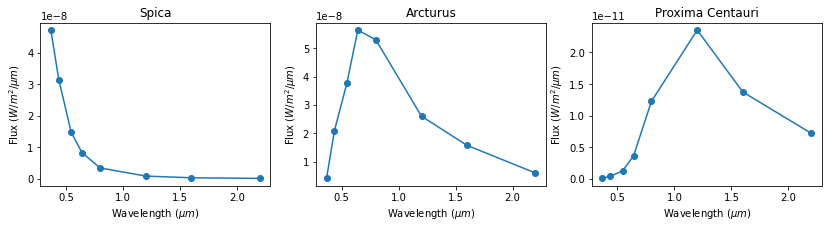

In [10]:
### now let's plot the first three
plt.rcParams['figure.figsize'] = (14,3)
ax1,ax2,ax3 = plt.subplot(131),plt.subplot(132),plt.subplot(133)
for star,ax in zip(['Spica','Arcturus','Proxima Centauri'],[ax1,ax2,ax3]):
    flux_densities = []
    for m,w,vega_AB in zip(magnitude_dict[star],filter_eff_wavelengths,vega_to_AB_conv):
        ABmag = (m + vega_AB)*u.ABmag
        lam = w*u.micron
        flam = ABmag.to(u.W/u.m**2/u.micron, u.spectral_density(lam))
        flux_densities += [flam.value]
    ax.plot(filter_eff_wavelengths[:-4],flux_densities,'o-')
    ax.set_title(star)
    ax.set_xlabel('Wavelength ($\mu m$)')
    ax.set_ylabel('Flux ($W/m^2/\mu m$)')

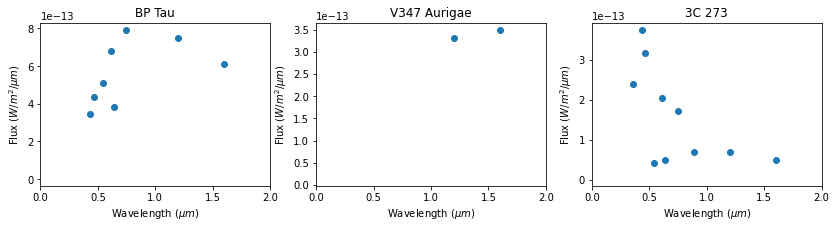

In [11]:
### now the next 3, including WISE
### I think some of the mags might be bad, we might need ugriz...
plt.rcParams['figure.figsize'] = (14,3)
ax1,ax2,ax3 = plt.subplot(131),plt.subplot(132),plt.subplot(133)
for star,ax in zip(['BP Tau','V347 Aurigae','3C 273'],[ax1,ax2,ax3]):
    flux_densities = []
    filt_eff_out = []
    for m,w,vega_AB in zip(magnitude_dict[star],filter_eff_wavelengths,vega_to_AB_conv):
        if m != m: continue
        #if w == 0.6407: continue
        #print(m,w)
        ABmag = (m + vega_AB)*u.ABmag
        lam = w*u.micron
        flam = ABmag.to(u.W/u.m**2/u.micron, u.spectral_density(lam))
        flux_densities += [flam.value]
        filt_eff_out += [w]
    ax.plot(filt_eff_out,flux_densities,'o')
    ax.set_title(star)
    ax.set_xlabel('Wavelength ($\mu m$)')
    ax.set_ylabel('Flux ($W/m^2/\mu m$)')
    ax.set_xlim([0,2])

Woah, some of this photometry looks bad!  Not good if measurements at the same wavelengths are drastically off.  Let's use Sloan filters alone for the optical wavelengths instead -- be careful, these are in AB mags.

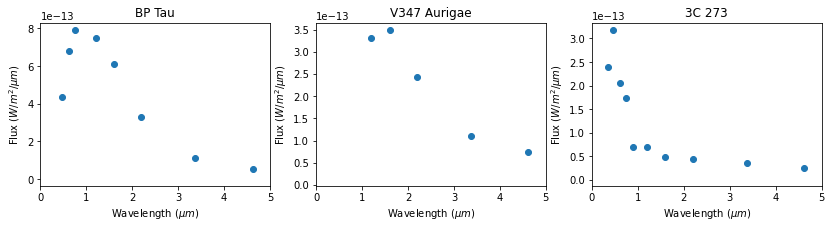

In [12]:
### now the next 3, including WISE
### I think some of the mags might be bad, we might need ugriz...
plt.rcParams['figure.figsize'] = (14,3)
ax1,ax2,ax3 = plt.subplot(131),plt.subplot(132),plt.subplot(133)
for star,ax in zip(['BP Tau','V347 Aurigae','3C 273'],[ax1,ax2,ax3]):
    flux_densities = []
    filt_eff_out = []
    for m,w,vega_AB in zip(magnitude_dict[star],filter_eff_wavelengths,vega_to_AB_conv):
        #if m != m: continue
        #if w == 0.6407: continue
        #print(m,w)
        ABmag = (m + vega_AB)*u.ABmag
        lam = w*u.micron
        flam = ABmag.to(u.W/u.m**2/u.micron, u.spectral_density(lam))
        flux_densities += [flam.value]
        filt_eff_out += [w]
    ax.plot(filt_eff_out[5:],flux_densities[5:],'o')
    ax.set_title(star)
    ax.set_xlabel('Wavelength ($\mu m$)')
    ax.set_ylabel('Flux ($W/m^2/\mu m$)')
    ax.set_xlim([0,5])

A little more reasonable!

### 3) Fit Temperature

#### 3.1) Fitting SED with a Planck Function
The black body equation as a function of wavelength is as follows:

$B_{\lambda}(\lambda,T) = \frac{2hc^2}{\lambda^5} \frac{1}{e^{hc/(\lambda k_B T)} - 1}$


Let's code this up as a function

In [13]:
_h = 6.626 * 10**(-34)  ## SI units
_c = 3e8 ### m/s
_kb = 1.3807 * 10**(-23)

def b_lambda(lam,T):
    lam_m = lam * 1e-6 # micron to m
    return 2*_h*_c**2/lam_m**5/(np.exp(_h*_c/(lam_m*_kb*T)) - 1)

def b_lam_fitting(x,lam=None,flux=None):
    amplitude,T = x
    b_model = amplitude*b_lambda(lam,T)
    return flux-b_model

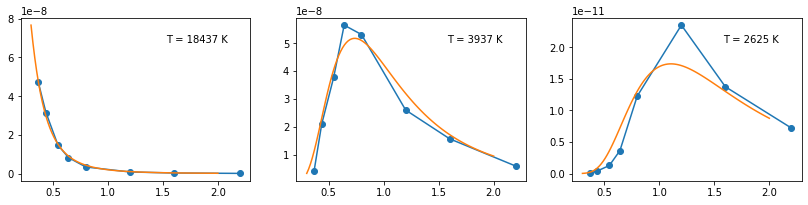

In [14]:
### iterate over the first three stars and fit the black body function
### this fitting isn't great -- we need a good initial guess for the amplitude and sometimes temperature
### so I tried some options here
plt.rcParams['figure.figsize'] = (14,3)
ax1,ax2,ax3 = plt.subplot(131),plt.subplot(132),plt.subplot(133)
amplitudes,temps = [],[]
for star,ax,amp_guess,temp_guess in zip(
        ['Spica','Arcturus','Proxima Centauri'],[ax1,ax2,ax3],[1e-20,1e-21,1e-20],[5000,3500,3000]):

    flux_densities = []
    wave_eff_out = []
    for m,w,vega_AB in zip(magnitude_dict[star],filter_eff_wavelengths,vega_to_AB_conv):
        if m != m: continue
        ABmag = (m + vega_AB)*u.ABmag
        lam = w*u.micron
        flam = ABmag.to(u.W/u.m**2/u.micron, u.spectral_density(lam))
        flux_densities += [flam.value]
        wave_eff_out += [w]
    flux_densities,wave_eff_out = np.array(flux_densities),np.array(wave_eff_out)
        
    result = least_squares(
        b_lam_fitting,[amp_guess,temp_guess],
        args=(wave_eff_out,flux_densities))
    ax.plot(wave_eff_out,flux_densities,'o-')
    lam = np.linspace(0.3,2,100)
    ax.plot(lam,result.x[0]*b_lambda(lam,result.x[1]))
    ax.text(0.9,0.9,f'T = {result.x[1]:.0f} K',ha='right',va='top',transform=ax.transAxes)
    amplitudes += [result.x[0]]
    temps += [result.x[1]]

#### 3.2.2
Spectral types for these three stars are B1, K1, M5.5.  From https://sites.uni.edu/morgans/astro/course/Notes/section2/spectraltemps.html I expect temperatures of 23,000, 5110, and 3200.  But, these stars are not perfect blackbodies and likely absorption features are biasing our temperature determinations.

Let's try the next three:

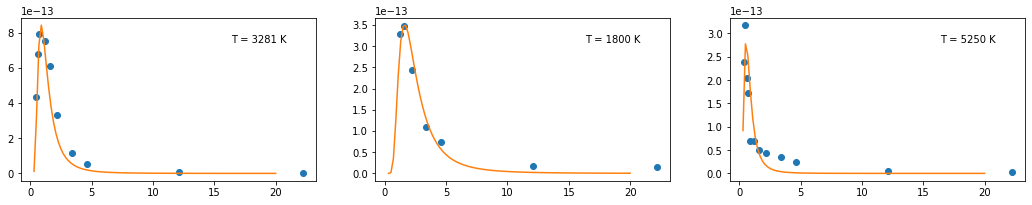

In [15]:
plt.rcParams['figure.figsize'] = (18,3)
ax1,ax2,ax3 = plt.subplot(131),plt.subplot(132),plt.subplot(133)
#amplitudes,temps = [],[]
for star,ax,amp_guess,temp_guess in zip(
        ['BP Tau','V347 Aurigae','3C 273'],[ax1,ax2,ax3],[1e-20,1e-21,1e-20],[5000,1800,3000]):

    flux_densities = []
    wave_eff_out = []
    for m,w,vega_AB in zip(magnitude_dict[star][5:],filter_eff_wavelengths[5:],vega_to_AB_conv[5:]):
        if m != m: continue
        ABmag = (m + vega_AB)*u.ABmag
        lam = w*u.micron
        flam = ABmag.to(u.W/u.m**2/u.micron, u.spectral_density(lam))
        flux_densities += [flam.value]
        wave_eff_out += [w]
    flux_densities,wave_eff_out = np.array(flux_densities),np.array(wave_eff_out)
        
    result = least_squares(
        b_lam_fitting,[amp_guess,temp_guess],
        args=(wave_eff_out,flux_densities))
    ax.plot(wave_eff_out,flux_densities,'o')
    lam = np.linspace(0.3,20,100)
    ax.plot(lam,result.x[0]*b_lambda(lam,result.x[1]))
    ax.text(0.9,0.9,f'T = {result.x[1]:.0f} K',ha='right',va='top',transform=ax.transAxes)
    amplitudes += [result.x[0]]
    temps += [result.x[1]]

OK, this looks pretty bad.  We could improve our initial guesses and maybe do a bit better, but also: stars are not perfect black bodies and in fact, 3C 273 is not a star at all!  (it's a quasar).

#### 3.2.3
Not perfect but pretty well.  Better for blue stars!

### 4) Calculate the Radius of the Stars

First we need to get an estimate of the total luminosity.  We can do that by integrating the planck function, including the amplitude offset from 0 -> some large number.

In [16]:
parallaxes = np.array([13.06e-3,88.83e-3,768e-3,7.8494e-3,4.8414e-3]) ## from Simbad, in mas
# for the first 5.  a parallax is listed in Simbad but it's **totally wrong**
distances = 1/parallaxes * 3.086e16
distances = np.append(distances,762.3e6 * 3.086e16) # this last number is using Ned Wright's cosmology calculator given the redshift
_sigma = 5.67e-8

for star,amp,t,d in zip(['Spica','Arcturus','Proxima Centauri','BP Tau','V347 Aurigae','3C 273'],amplitudes,temps,distances):
    blt = lambda x: b_lambda(x,t)
    flux = amp*quad(blt,0,20)[0]
    lum = 4*np.pi*d**2.*flux
    print(star)
    print(f"luminosity = {lum:8.3e} W, {lum/3.86e26:.3f} solar luminosities")
    
    radius = np.sqrt(lum/(4*np.pi*_sigma*t**4))
    print(f"radius = {radius:8.3e} m, {radius/6.96e8:.3f} solar radii")
    print("")

Spica
luminosity = 2.853e+30 W, 7390.787 solar luminosities
radius = 5.886e+09 m, 8.457 solar radii

Arcturus
luminosity = 8.779e+28 W, 227.446 solar luminosities
radius = 2.264e+10 m, 32.530 solar radii

Proxima Centauri
luminosity = 5.922e+23 W, 0.002 solar luminosities
radius = 1.323e+08 m, 0.190 solar radii

BP Tau
luminosity = 2.199e+26 W, 0.570 solar luminosities
radius = 1.632e+09 m, 2.344 solar radii

V347 Aurigae
luminosity = 4.388e+26 W, 1.137 solar luminosities
radius = 7.659e+09 m, 11.004 solar radii

3C 273
luminosity = 1.663e+39 W, 4309123705634.241 solar luminosities
radius = 1.753e+15 m, 2518626.873 solar radii



/var/folders/gb/ltvsdtcj74j7xf7pyycyvf7r000g2p/T/ipykernel_53446/3811477948.py:7: RuntimeWarning: overflow encountered in exp
  return 2*_h*_c**2/lam_m**5/(np.exp(_h*_c/(lam_m*_kb*T)) - 1)
